In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Markov Models')

In [0]:
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
def random_normalized(d1, d2):
    x = np.random.random((d1,d2))
    return x / x.sum(axis=1, keepdims=True)

In [0]:
class HMM:
    def __init__(self, M):
        self.M = M #number of hidden states

    def fit(self, X, max_iter=30):
        t0 = datetime.now()
        np.random.seed(123)
        #train the HMM model using Baum-Welch algorithm
        #a specific instance of the expectation-maximization algorithm

        #determine V, the vocabulary size
        #assume observables are already integers from 0.. V-1
        #X is a jagged array of observed sequences
        V = max(max(x) for x in X) + 1
        N = len(X)
        self.pi = np.ones(self.M) / self.M #initial state distribution
        self.A = random_normalized(self.M, self.M) #state transition matrix
        self.B = random_normalized(self.M, V) #output distribution

        print("initial A:", self.A)
        print("initial B:", self.B)

        costs = []
        for it in range(max_iter):
            if it % 10 == 0:
                print("it", it)
            alphas = []
            betas = []
            P = np.zeros(N)
            for n in range(N):
                x = X[n]
                T = len(x)

                #calculate alpha
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi * self.B[:, x[0]] #calculate the 1st element
                for t in range(1, T):
                    tmp1 = alpha[t-1].dot(self.A) * self.B[:, x[t]]
                    alpha[t] = tmp1
                P[n] = alpha[-1].sum()
                alphas.append(alpha)

                #calculate beta
                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T-2, -1, -1):
                    beta[t] = self.A.dot(self.B[:, x[t+1]] * beta[t+1])
                betas.append(beta)

            assert(np.all(P > 0))
            cost = np.sum(np.log(P))
            costs.append(cost)

            #now re-estimate pi, A ,B
            self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(N)) / N

            den1 = np.zeros((self.M, 1))
            den2 = np.zeros((self.M, 1))
            a_num = 0
            b_num = 0
            for n in range(N):
                x = X[n]
                T = len(x)
                den1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T / P[n]
                den2 += (alphas[n] * betas[n]).sum(axis=0, keepdims=True).T / P[n]

                #numerator for A
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i] * self.A[i,j] * self.B[j, x[t+1]] * betas[n][t+1, j]
                a_num += a_num_n / P[n]

                #numerator for B
                b_num_n2 = np.zeros((self.M, V))
                for i in range(self.M):
                    for t in range(T):
                        b_num_n2[i, x[t]] += alphas[n][t,i] * betas[n][t,i]
                b_num += b_num_n2 / P[n]

            self.A = a_num / den1
            self.B = b_num / den2

        print("A:", self.A)
        print("B:", self.B)
        print("pi:", self.pi)

        print("Fit duration:", (datetime.now() - t0))

        plt.plot(costs)
        plt.show()

    def likelihood(self, x):
        #return log P(x | model)
        #using the forward part of the forward-backward algorithm
        T = len(x)
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi * self.B[:, x[0]]
        for t in range(1, T):
            alpha[t] = alpha[t-1].dot(self.A) * self.B[:,x[t]]
        return alpha[-1].sum()

    def likelihood_multi(self, X):
        return np.array([self.likelihood(x) for x in X])

    def log_likelihood_multi(self, X):
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        #returns the most likely state sequence given observed sequence x
        #using the viterbi algorithm
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi * self.B[:, x[0]]
        for t in range(1,T):
            for j in range(self.M):
                delta[t, j] = np.max(delta[t-1] * self.A[:,j]) * self.B[j, x[t]]
                psi[t, j] = np.argmax(delta[t-1] * self.A[:, j])

        #backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]

        return states    

In [0]:
def fit_coin():
    X = []
    for line in open('coin_data.txt'):
        # 1 for H, 0 for T
        x = [1 if e == 'H' else 0 for e in line.rstrip()]
        X.append(x)

    hmm = HMM(2)
    hmm.fit(X)
    L = hmm.log_likelihood_multi(X).sum()
    print("LL with fitted params:", L)

    #try some values 
    hmm.pi = np.array([0.5, 0.5])
    hmm.A = np.array([[0.1, 0.9], [0.8, 0.2]])
    hmm.B = np.array([[0.6, 0.4], [0.3, 0.7]])
    L = hmm.log_likelihood_multi(X).sum()
    print("LL with True params:", L)

    #try viterbi
    print("Best state sequence for:", X[0], '\n')
    print(hmm.get_state_sequence(X[0]))

initial A: [[0.7087962  0.2912038 ]
 [0.29152056 0.70847944]]
initial B: [[0.62969057 0.37030943]
 [0.58883752 0.41116248]]
it 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


it 10
it 20
A: [[0.70386662 0.29613338]
 [0.28712763 0.71287237]]
B: [[0.54419694 0.45580306]
 [0.53723247 0.46276753]]
pi: [0.50695647 0.49304353]
Fit duration: 0:00:00.704442


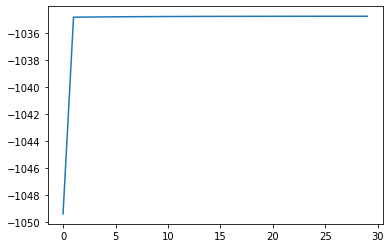

LL with fitted params: -1034.7557547352071
LL with True params: -1059.7229160265022
Best state sequence for: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1] 

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [37]:
if __name__ =='__main__':
    fit_coin()

From the plot we can see that expectation-maximization converges very fast.
We also see that fitted log-likelihood is better than true log-likelihood.